In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer

#Modele de prediction
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

#Modeles  de machine learning
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression,ElasticNet, Ridge, Lasso

#Indicateurs des performances du modele 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import shap
import time

import lime
from lime import lime_tabular
import random


## Fonctions

In [2]:
# fonction qui remove les colonnes 
def remove_column(df,columns):
    df.drop(labels=columns,axis=1, inplace= True)

In [3]:
# fonction qui efface les lignes aves des valeurs Nan
def imputation(df):
    return df.dropna(axis=0)

In [4]:
# fonction qui transforme les variables de type quantitave dans un tableau des valeurs qualitatives 
def ohe(df,labels):
    ohe = OneHotEncoder()
    feature_arry=ohe.fit_transform(df[[labels]]).toarray()
    feature_labels=ohe.categories_
    features =pd.DataFrame(feature_arry, columns=feature_labels)
    return features

In [5]:
# fonction qui applique la methode LabelEncoder aux variables 
def labels(df, labels):
    le = LabelEncoder()
    le.fit(df[labels])
    val =le.transform(df[labels])
    remove_column(df,labels)
    df = pd.concat(
        [df, pd.DataFrame(val,columns=[labels])], axis=1)
    return df

In [6]:
# fonction qui complete les valeurs manquantes du dataframe avec la methode des k plus proches voisins 
def knn_imputer(df,k):

    imputer = KNNImputer(n_neighbors=k)
    After_imputation = imputer.fit_transform(df)
    df = pd.DataFrame(After_imputation,columns = df.columns)

    return df

In [7]:
# fonction qui prepare les variables a observer 
def preprocessing(data,labels):
    
    X = data.drop([labels],axis=1)
    y = data[labels]
    
    return X,y

In [8]:
# fonction qui renvoi les characteristiques du modele de prediction
def characteristic(y_test,y_predict):
    
    R2=r2_score(y_test,y_predict)
    MCE=mean_squared_error(y_test,y_predict)
    RMCE=np.sqrt(mean_squared_error(y_test,y_predict))
    MAE=median_absolute_error(y_test,y_predict)
    
    return R2,MCE,RMCE,MAE

In [9]:
# fonction qui rempli et organise le tableau des modeles selon la valeur R2
def df_score(df_scores,modele, R2, RMCE, MAE):
    df_scores.loc[df_scores.shape[0]] = [modele, R2, RMCE, MAE]
    df_scores.sort_values(by='R2', ascending=False, inplace=True)
    df_scores.drop_duplicates(subset=['modele'], keep='last', inplace=True)
    df_scores.reset_index(drop=True, inplace=True)
    
    return df_scores

In [10]:
# fonction qui entraine les modeles et renvoi les valeurs du tableau 
def model_evaluation(modele,df_scores):
     
    modele.fit(X_train, y_train)
    y_predict=modele.predict(X_test)
    
    R2,MCE,RMCE,MAE=characteristic(y_test,y_predict)
    df_score(df_scores,modele, R2, RMCE, MAE)
          
    return df_scores

In [11]:
# fonction qui renvoi le temps d'entrainement des modeles 
def train_model(model): 
   
    pipe = Pipeline([('scaler', StandardScaler()),('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time
  
    train_accuracy =  pipe.score(X_train, y_train)
    test_accuracy = pipe.score(X_test, y_test) 
    model_details = {"name": model["name"], "train_accuracy":train_accuracy, "test_accuracy":test_accuracy, "train_time": train_time, "model": pipe}
    return model_details

In [12]:
# fonction qui applique la cross validation, fonction utilisé pour tester la robustesse 
def validation_croise(model,X, y):
    score = cross_val_score(model, X, y, cv=5 ,scoring='r2')
    return score

In [13]:
# fonction qui renvoi les meilleurs hyperparametres des modeles, il rempli aussi un table avec les differents scores du model
def hyperparameter(df_scores,modele,parametre):
    
    recherche_hyper=GridSearchCV(modele,parametre,cv=5,scoring='r2')
    recherche_hyper.fit(X_train, y_train)
    y_predict = recherche_hyper.predict(X_test)
    
    print(modele,recherche_hyper.best_params_)

    R2,MCE,RMCE,MAE=characteristic(y_test,y_predict)
    recherche_hyper=df_score(df_scores,modele, R2, RMCE, MAE)
    return recherche_hyper

# Modele de Prediction

On recupere le dataframe nettoyé dans la premiere partie

In [14]:
df=pd.read_csv('building-energy-cleaned.csv')

Dans la suite de notre analyse, on utilisera la variable PrimaryPropertyType, pour realiser les prediction on ne prendra pas en compte la variable BuildingType 

In [15]:
remove_column(df,'BuildingType')

## 1) Etude de la consomation energetique sans la variable ENERGYSTARScore

### 1.1) Encodage

In [16]:
categorical = df.select_dtypes('object')
for col in categorical:
        df=labels(df,col)

Pour commencer on realisera une analyse sans prendre en compte les valeurs de ENERGYSTARScore, ce pour cela qu'on creera une nouvelle dataframe qui ne prendra pas en compte cette variable. 

Mais avant d'effacer la variable ENERGYSTARScore, on realisera une reduction de notre dataframe pour eviter que notre analyse sois faussé a cause des valeurs manquantes sur la variable ENERGYSTARScore.

In [17]:
df_test=df.copy()
df_test=df_test.dropna(axis = 0)
remove_column(df_test,'ENERGYSTARScore')

Dans la partie anterieur ont a vu qu'il y avais des données qui sont tres correlés entres elle par exemple SteamUse, Electricity et TotalGHGEmissions, si on prend en compte ses valeurs dans nos predictions, elles ne serons pas realistes car on apporterait les solutions a la prediction, c'est pour cela que ces variables seron effacé. Pour la variable HistoricalPeriod, ayant deja une variable qui apportent des information par rapport au temps, on tiendra pas compte de cette variable. La variable BuildingRate n'etant pas tres corrélés avec les variables a predire, l'information qu'elle nous apporterait n'aura pas beaucoup d'influence.

In [18]:
remove_column(df_test,['TotalGHGEmissions','SteamUse','Electricity','BuildingRate','HistoricalPeriod'])

### 1.2) Standardisation 

Dans cette section on va normaliser les valeurs des variables afin d'eviter, les ecarts du aux differents unités 

In [19]:
column=df_test.columns.values
scaler = MinMaxScaler()
scaler.fit(df_test)
df_np=scaler.transform(df_test)
labels=df_test.columns

In [20]:
df_test=pd.DataFrame(df_np,columns=column)

### 1.3) Echantillonage

In [21]:
trainset, testset = train_test_split(df_test, test_size=0.2, random_state=0)

In [22]:
X_train, y_train = preprocessing(trainset,'SiteEnergyUse')

In [23]:
X_test, y_test = preprocessing(testset,'SiteEnergyUse')

### 1.4) Evaluation des hyper parametres 

In [24]:
score=[]
df_scores = pd.DataFrame(
    score, columns=['modele', 'R2', 'RMSE', 'MAE'])

In [25]:
parametre_LR ={}
hyperparameter(df_scores,LinearRegression(),parametre_LR)

LinearRegression() {}


,modele,R2,RMSE,MAE
0,LinearRegression(),0.01164,0.035997,0.00523


In [26]:
parametre_Lasso={}
hyperparameter(df_scores,Lasso(),parametre_Lasso)

Lasso() {}


,modele,R2,RMSE,MAE
0,LinearRegression(),0.011640,0.035997,0.005230
1,Lasso(),-0.070014,0.037454,0.022722


In [27]:
parametre_Ridge={}
hyperparameter(df_scores,Ridge(),parametre_Ridge)

Ridge() {}


,modele,R2,RMSE,MAE
0,Ridge(),0.500343,0.025594,0.005705
1,LinearRegression(),0.011640,0.035997,0.005230
2,Lasso(),-0.070014,0.037454,0.022722


In [28]:
parametre_EN={"max_iter": [1, 5, 10], "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], "l1_ratio": np.arange(0.0, 1.0, 0.1)}
hyperparameter(df_scores,ElasticNet(),parametre_EN)

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.221e-01, tolerance: 4.018e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.384e-01, tolerance: 4.242e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.116e-01, tolerance: 3.916e-04 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.616e-01, tolerance: 4.974e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e-01, tolerance: 4.018e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.830e-01, tolerance: 4.242e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-01, tolerance: 3.916e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.416e-01, tolerance: 3.737e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e-02, tolerance: 3.737e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.875e-01, tolerance: 4.974e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e-03, tolerance: 4.018e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-03, tolerance: 4.242e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e-02, tolerance: 3.916e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.613e-01, tolerance: 4.242e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.292e-01, tolerance: 3.916e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.194e-01, tolerance: 3.737e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.886e-01, tolerance: 4.974e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.710e-03, tolerance: 4.018e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.277e-01, tolerance: 4.242e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.617e-01, tolerance: 3.916e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.447e-01, tolerance: 3.737e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.394e-01, tolerance: 4.974e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.345e-03, tolerance: 4.018e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.207e-02, tolerance: 4.242e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.122e-02, tolerance: 3.916e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.898e-02, tolerance: 3.737e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e-01, tolerance: 4.974e-04
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.374e-02, tolerance: 4.018e-04
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e+00, tolerance: 4.018e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+00, tolerance: 4.242e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e+00, tolerance: 3.916e-04 Linear regression models with null weig

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+00, tolerance: 4.018e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e+00, tolerance: 4.242e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e+00, tolerance: 3.916e-04 Linear regression models with null weig

ElasticNet() {'alpha': 0.0001, 'l1_ratio': 0.9, 'max_iter': 10}


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.572e-04, tolerance: 5.223e-04


,modele,R2,RMSE,MAE
0,Ridge(),0.500343,0.025594,0.005705
1,ElasticNet(),0.248057,0.031398,0.004333
2,LinearRegression(),0.011640,0.035997,0.005230
3,Lasso(),-0.070014,0.037454,0.022722


In [29]:
parametre_SVM ={'C':[1, 10]}
hyperparameter(df_scores,LinearSVR(),parametre_SVM)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


LinearSVR() {'C': 1}


Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


,modele,R2,RMSE,MAE
0,LinearSVR(),0.876914,0.012703,0.002829
1,Ridge(),0.500343,0.025594,0.005705
2,ElasticNet(),0.248057,0.031398,0.004333
3,LinearRegression(),0.011640,0.035997,0.005230
4,Lasso(),-0.070014,0.037454,0.022722


In [30]:
parametre_KNR = {'n_neighbors': np.arange(1, 30,1), 'metric': ['euclidean', 'manhattan', 'minkowski']}
hyperparameter(df_scores,KNeighborsRegressor(),parametre_KNR)

KNeighborsRegressor() {'metric': 'euclidean', 'n_neighbors': 1}


,modele,R2,RMSE,MAE
0,LinearSVR(),0.876914,0.012703,0.002829
1,Ridge(),0.500343,0.025594,0.005705
2,ElasticNet(),0.248057,0.031398,0.004333
3,LinearRegression(),0.011640,0.035997,0.005230
4,Lasso(),-0.070014,0.037454,0.022722
5,KNeighborsRegressor(),-0.323510,0.041655,0.005381


In [31]:
parametre_DTR = {"max_depth": [1, 3, 5, 7, 9, 11, 12],"max_features": ["auto", "log2", None]}
hyperparameter(df_scores,DecisionTreeRegressor(),parametre_DTR)

DecisionTreeRegressor() {'max_depth': 7, 'max_features': None}


,modele,R2,RMSE,MAE
0,LinearSVR(),0.876914,0.012703,0.002829
1,Ridge(),0.500343,0.025594,0.005705
2,ElasticNet(),0.248057,0.031398,0.004333
3,LinearRegression(),0.011640,0.035997,0.005230
4,Lasso(),-0.070014,0.037454,0.022722
5,KNeighborsRegressor(),-0.323510,0.041655,0.005381
6,DecisionTreeRegressor(),-4.182821,0.082431,0.003100


In [32]:
parametre_RFR = {"max_depth": [1, 3, 5, 7, 9, 11, 12],"max_features": ["auto", "log2", None], "min_samples_leaf":[1,2,4]}
hyperparameter(df_scores,RandomForestRegressor(),parametre_RFR)

RandomForestRegressor() {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1}


,modele,R2,RMSE,MAE
0,LinearSVR(),0.876914,0.012703,0.002829
1,RandomForestRegressor(),0.600785,0.022878,0.004099
2,Ridge(),0.500343,0.025594,0.005705
3,ElasticNet(),0.248057,0.031398,0.004333
4,LinearRegression(),0.011640,0.035997,0.005230
5,Lasso(),-0.070014,0.037454,0.022722
6,KNeighborsRegressor(),-0.323510,0.041655,0.005381
7,DecisionTreeRegressor(),-4.182821,0.082431,0.003100


In [33]:
parametre_XG = {"max_depth": [1, 3, 5, 7, 9, 11, 12], "max_features": ["auto","sqrt", "log2", None]}
hyperparameter(df_scores,GradientBoostingRegressor(),parametre_XG)

GradientBoostingRegressor() {'max_depth': 5, 'max_features': 'sqrt'}


,modele,R2,RMSE,MAE
0,LinearSVR(),0.876914,0.012703,0.002829
1,RandomForestRegressor(),0.600785,0.022878,0.004099
2,Ridge(),0.500343,0.025594,0.005705
3,GradientBoostingRegressor(),0.295321,0.030395,0.002292
4,ElasticNet(),0.248057,0.031398,0.004333
5,LinearRegression(),0.011640,0.035997,0.005230
6,Lasso(),-0.070014,0.037454,0.022722
7,KNeighborsRegressor(),-0.323510,0.041655,0.005381
8,DecisionTreeRegressor(),-4.182821,0.082431,0.003100


In [34]:
df_scores['modele']=['SVM','Random Forest Regressor','Ridge','ElasticNet','Gradient Boosting Regressor',
                     'Linear Regression','Lasso','K Neighbors Regressor','Decision Tree Regressor']

Text(0.5, 0, 'R2 Score')

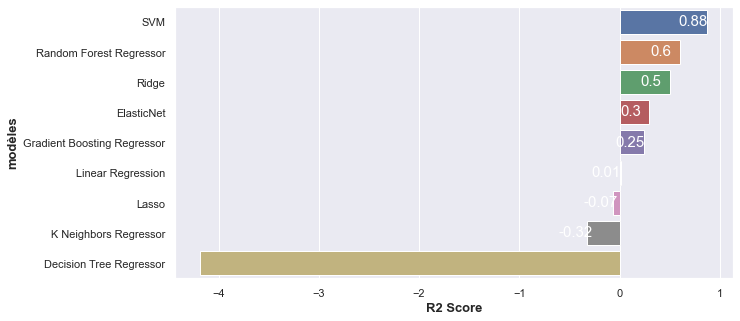

In [85]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=df_scores['R2'],
                       y=df_scores['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.39, p.get_y() + 0.05 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')
    
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

De ceci, on peut dire que les meilleurs modeles pour la prediction de la consomation d'energie est le model SVM, Random Forest et Ridge, etant le model SVM le plus performant. Dans la suite on realisera une comparaison entre ces modeles afin de determiner le temps qu'il prendra a son entrainement et execution, pour cela on prendra les meilleurs HyperParametres que la methode GridSearchCV nous a donné, qui sont les suivants:

    a)LinearSVR() {'C': 1} Pour le SVM
    b)RandomForestRegressor() {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1} Pour le RandomForest
    c)le modele Ridge n'ayant pas des hyperparametres, on utilisera les valeurs par defauts

### 1.5) Modeles utilisez

In [36]:
Ridge=Ridge()
SVM=LinearSVR(C=1)
Random_Forest_Regressor=RandomForestRegressor(max_depth=7, max_features='log2',min_samples_leaf=1)

In [37]:
model_energie = [Ridge, SVM, Random_Forest_Regressor]
nom_model=['Ridge','SVM','Random Forest Regressor']

### 1.5.1) Evaluation des modeles avec R2 score

In [38]:
evaluation_models = [] 
evaluation_model=pd.DataFrame(evaluation_models,columns=['modele', 'R2', 'RMCE', 'MAE'])

for model in model_energie:
    model_info = model_evaluation(model,evaluation_model)

Liblinear failed to converge, increase the number of iterations.


In [39]:
evaluation_model

,modele,R2,RMCE,MAE
0,LinearSVR(C=1),0.880668,0.012508,0.002962
1,"(DecisionTreeRegressor(max_depth=7, max_featur...",0.622023,0.022261,0.004217
2,Ridge(),0.500343,0.025594,0.005705


In [40]:
evaluation_model['modele']=['SVM','Random Forest Regressor','Ridge']

In [41]:
evaluation_model

,modele,R2,RMCE,MAE
0,SVM,0.880668,0.012508,0.002962
1,Random Forest Regressor,0.622023,0.022261,0.004217
2,Ridge,0.500343,0.025594,0.005705


Text(0.5, 0, 'R2 Score')

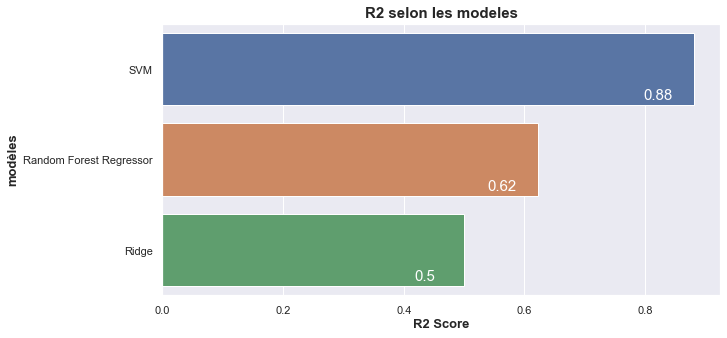

In [72]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=evaluation_model['R2'],
                       y=evaluation_model['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.05 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')
    
plt.title('R2 selon les modeles', size=15, weight='bold')
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

On observe bien, que la meilleur prediction est réalisé par le modele SVM, suivi par le RandomForest, il est possible alors de se poser comme question, sinon sont assez robuste, ce pour cela que dans la suite on realisera un CrossValidation.

### 1.5.2) Evaluation de la robustesses des modeles 

In [43]:
cross_validation = []
for models in model_energie:
    cross_val = validation_croise(models,X_train, y_train)
    cross_validation.append(cross_val)

val_cross=pd.DataFrame(cross_validation,columns=['R2(0)','R2(1)','R2(2)','R2(3)','R2(4)'])
val_cross['nom']=nom_model

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


In [44]:
val_cross

,R2(0),R2(1),R2(2),R2(3),R2(4),nom
0,0.684350,0.792006,0.323436,0.607690,0.654316,Ridge
1,0.337906,0.906524,0.370230,0.423327,0.885030,SVM
2,0.720104,0.777831,0.525955,0.678039,0.746767,Random Forest Regressor


De ceci, on peut en deduire que les meilleurs scores sont données par le modele SVM mais qu'il est trop sensible aux variations des données, ce qui rend sa robustesse trop faible, par contre le model RandomForest ayant pas une meilleur score R2 que le model SVM, il est plus robuste au changement des données. On peut donc dire que pour que le modele SVM fonctionne mieux il est necessaire d'acquerir plus des données. 

### 1.5.3) Evaluation du Temps d'entrenaiment

In [45]:
models = [{"name": "Ridge", "clf": Ridge},
          {"name": "SVM", "clf": SVM},  
          {"name": "Random Forest Regressor", "clf": Random_Forest_Regressor}]

In [46]:
trained_models = []
for model in models:
    model_details = train_model(model)
    trained_models.append(model_details)
    
model_entrene=pd.DataFrame(trained_models)

Liblinear failed to converge, increase the number of iterations.


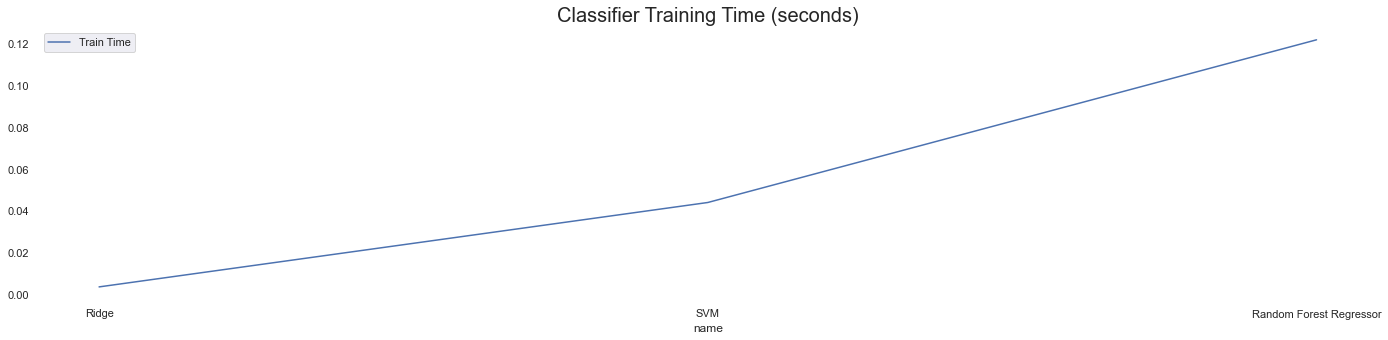

In [47]:
model_df = pd.DataFrame(trained_models)
model_df.sort_values("train_time", inplace=True)
ax= model_df[["train_time","name"]].plot(kind="line", x="name", figsize=(24,5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

Par rapport au temps d'entrenaiment, on observe que le temps qui prend RandomForestRegressor est 6 fois celui du model SVM.

## 2) Etude de la consomation energetique avec la variable ENERGYSTARScore

Dans cette partie, on realisera le même etude realisé dans la section 1.4.1 afin de determiner si la variable ENERGYSTARScore a une influence positive sur la predection de la consomation d'energie

In [48]:
df_energie_score=df.copy()
df_energie_score=df_energie_score.dropna(axis = 0)

### 2.1) Standardisation

In [49]:
column=df_energie_score.columns.values
scaler = MinMaxScaler()
scaler.fit(df_energie_score)
df_np=scaler.transform(df_energie_score)

In [50]:
df_test=pd.DataFrame(df_np,columns=column)

In [51]:
remove_column(df_test,['TotalGHGEmissions','SteamUse','Electricity','BuildingRate','HistoricalPeriod'])

On cree les variables des test 

### 2.2) Echantillonage

In [52]:
trainset, testset = train_test_split(df_test, test_size=0.2, random_state=0)

In [53]:
X_train, y_train = preprocessing(trainset,'SiteEnergyUse')

In [54]:
X_test, y_test = preprocessing(testset,'SiteEnergyUse')

### 2.3) Test du meilleur model

In [55]:
best=[]
df_best = pd.DataFrame(
    best, columns=['modele', 'R2', 'RMSE', 'MCE'])
model_evaluation(SVM,df_best)

Liblinear failed to converge, increase the number of iterations.


,modele,R2,RMSE,MCE
0,LinearSVR(C=1),0.878156,0.012639,0.003353


In [56]:
model_evaluation(Random_Forest_Regressor,df_best)

,modele,R2,RMSE,MCE
0,LinearSVR(C=1),0.878156,0.012639,0.003353
1,"(DecisionTreeRegressor(max_depth=7, max_featur...",0.615838,0.022442,0.004421


In [59]:
df_best['modele']=['SVM','Random Forest Regressor']
df_best

,modele,R2,RMSE,MCE
0,SVM,0.878156,0.012639,0.003353
1,Random Forest Regressor,0.615838,0.022442,0.004421


Text(0.5, 0, 'R2 Score')

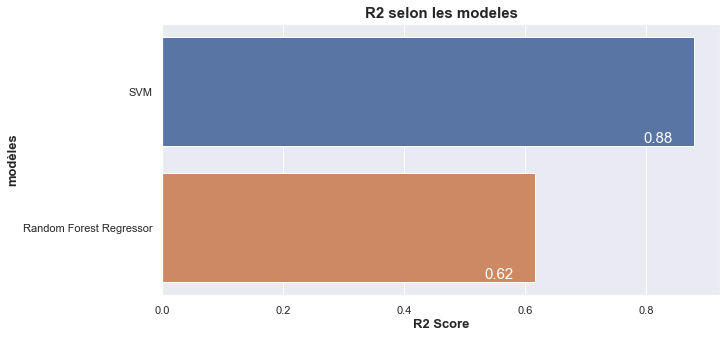

In [71]:
sns.set(rc={'figure.figsize':(14,14)})
plt.figure(figsize=(10, 5))

img=sns.barplot(x=df_best['R2'],
                       y=df_best['modele']
                       ) 
for p in img.patches:
    img.annotate(format(round(p.get_width(),2)),
                      (p.get_width() - 0.1, p.get_y() + 0.05 + p.get_height()),
                      color='#ffffff',
                      fontsize=15,
                      xytext=(10, 10),
                      textcoords='offset points')
    
plt.title('R2 selon les modeles', size=15, weight='bold')
plt.ylabel('modèles', size=13, weight='bold')
plt.xlabel('R2 Score', size=13, weight='bold')

On observe que la variable ENERGYSTARScore n'as pas beaucoup d'influence sur la prediction de la consomation d'energie, s'il a un influence, c'est une influence quasi negligeable, on observera plus en profondeur, dans les graphes d'influence des variables.

## 2.4) Etude de l'influence des variables par rapport aux modeles

Intercept 0.05177419522552249
Prediction_local [0.11911394]
Right: 0.05229822222433254


X does not have valid feature names, but LinearSVR was fitted with feature names


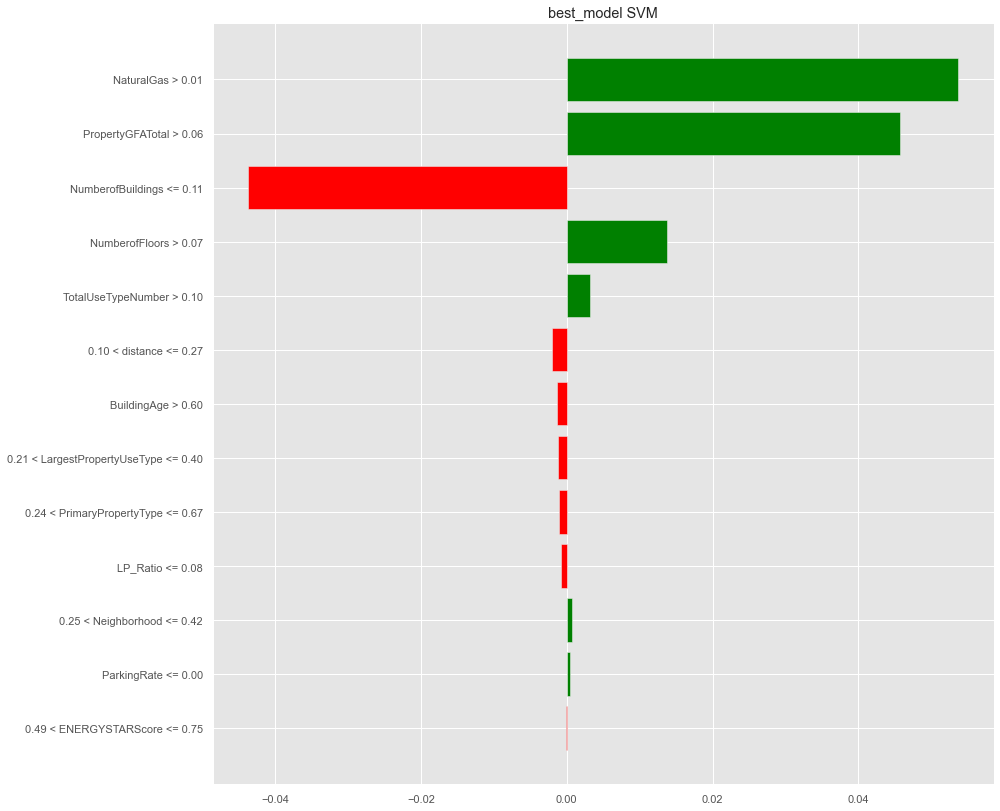

In [69]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')
exp = explainer.explain_instance(X_test.values[100], SVM.predict, num_features=len(X_train.columns.values.tolist()))
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.title('best_model SVM')

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 0.09894926541993249
Prediction_local [0.14605307]
Right: 0.05066447129324765


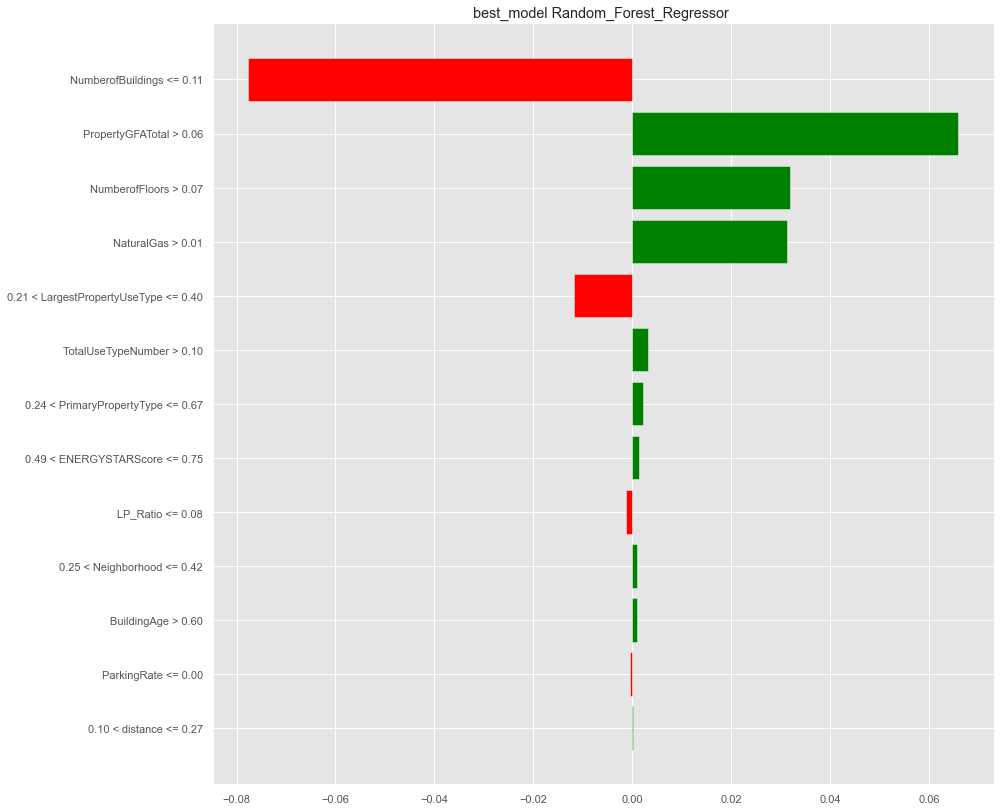

In [70]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['MEDV'], verbose=True, mode='regression')
exp = explainer.explain_instance(X_test.values[100], Random_Forest_Regressor.predict, num_features=len(X_train.columns.values.tolist()))
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.title('best_model Random_Forest_Regressor ')

Comme on observe ci-dessus, la participation de la variable ENERGYSTARScore a une petite influence negative sur le modele SVM, par contre il a une petite influence positive sur le modele Random Forest.